# Part I

https://towardsdatascience.com/how-to-do-deep-learning-on-graphs-with-graph-convolutional-networks-7d2250723780

<img src='https://miro.medium.com/max/864/1*jTW7doI_cqC_p9XQrmuu9A.png'>

In [1]:
import numpy as np

In [4]:
# adjacency matrix
A = np.matrix([
    [0, 1, 0, 0],
    [0, 0, 1, 1], 
    [0, 1, 0, 0],
    [1, 0, 1, 0]],
    dtype=float)

print(A)

[[0. 1. 0. 0.]
 [0. 0. 1. 1.]
 [0. 1. 0. 0.]
 [1. 0. 1. 0.]]


In [5]:
# feature matrix
X = np.matrix([
            [i, -i]
            for i in range(A.shape[0])
        ], dtype=float)

print(X)

[[ 0.  0.]
 [ 1. -1.]
 [ 2. -2.]
 [ 3. -3.]]


In [6]:
# propogation rule f(H^i,A)= sigma(AH^iW^i) 
# for i=1, sigma - id.function and AH^iW^i = AXW^i = AX
A@X

matrix([[ 1., -1.],
        [ 5., -5.],
        [ 1., -1.],
        [ 2., -2.]])

In [7]:
# add self-loops to add its own features
I = np.matrix(np.eye(A.shape[0]))

A_hat = A+I
print(A_hat)

A_hat@X

[[1. 1. 0. 0.]
 [0. 1. 1. 1.]
 [0. 1. 1. 0.]
 [1. 0. 1. 1.]]


matrix([[ 1., -1.],
        [ 6., -6.],
        [ 3., -3.],
        [ 5., -5.]])

Normalize values (as some nodes may have big range of degree):

In [27]:
# Degree matrix 
D = np.array(np.sum(A, axis=1)).reshape(1,-1)[0]
D = np.matrix(np.diag(D))
print(D)

[[1. 0. 0. 0.]
 [0. 2. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 2.]]


In [28]:
from numpy.linalg import inv

Dinv = inv(D)
Dinv

matrix([[1. , 0. , 0. , 0. ],
        [0. , 0.5, 0. , 0. ],
        [0. , 0. , 1. , 0. ],
        [0. , 0. , 0. , 0.5]])

In [30]:
print(A)
Dinv@A # inverse of degree matrix => norm. adj.matrix

[[0. 1. 0. 0.]
 [0. 0. 1. 1.]
 [0. 1. 0. 0.]
 [1. 0. 1. 0.]]


matrix([[0. , 1. , 0. , 0. ],
        [0. , 0. , 0.5, 0.5],
        [0. , 1. , 0. , 0. ],
        [0.5, 0. , 0.5, 0. ]])

In [31]:
Dinv@A@X # node representaion is mean of the features of neighboring nodes. 

matrix([[ 1. , -1. ],
        [ 2.5, -2.5],
        [ 1. , -1. ],
        [ 1. , -1. ]])

Adding together: self-loops, normalization, weights:

In [33]:
W = np.matrix([
             [1, -1],
             [-1, 1]])
W

matrix([[ 1, -1],
        [-1,  1]])

In [35]:
Dinv@A_hat@X@W      # (NxN)@(NxN)@(NxD)@(DxD^next layer) => (NxD^next layer)

matrix([[ 2., -2.],
        [ 6., -6.],
        [ 6., -6.],
        [ 5., -5.]])

In [38]:
# add activation function

def relu(x):
    return np.multiply(x,(x > 0))

relu(Dinv@A_hat@X@W)

matrix([[ 2., -0.],
        [ 6., -0.],
        [ 6., -0.],
        [ 5., -0.]])

### Zachary’s Karate Club

"Zachary’s karate club is a commonly used social network where nodes represent members of a karate club and the edges their mutual relations. While Zachary was studying the karate club, a conflict arose between the administrator and the instructor which resulted in the club splitting in two. The figure below shows the graph representation of the network and nodes are labeled according to which part of the club. The administrator and instructor are marked with ‘A’ and ‘I’, respectively."

<img src='https://miro.medium.com/max/1400/1*d62WDGX4uf6bwlu0KyfRsQ.png'>

In [39]:
from networkx import karate_club_graph, to_numpy_matrix

zkc = karate_club_graph()
zkc

In [40]:
order = sorted(list(zkc.nodes()))
order

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33]

In [41]:
A = to_numpy_matrix(zkc, nodelist=order)
A

matrix([[0., 1., 1., ..., 1., 0., 0.],
        [1., 0., 1., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 1., 0.],
        ...,
        [1., 0., 0., ..., 0., 1., 1.],
        [0., 0., 1., ..., 1., 0., 1.],
        [0., 0., 0., ..., 1., 1., 0.]])

In [58]:
I = np.eye(zkc.number_of_nodes())

A_hat = A + I
D_hat = np.array(np.sum(A_hat, axis=0))[0] # note, here is out-degree matrix, not in-degree
D_hat = np.matrix(np.diag(D_hat))

In [59]:
W_1 = np.random.normal(
    loc=0, scale=1, size=(zkc.number_of_nodes(), 4))
W_2 = np.random.normal(
    loc=0, size=(W_1.shape[1], 2))

In [60]:
def gcn_layer(A_hat, D_hat, X, W):
    return relu(D_hat**-1 * A_hat * X * W)

H_1 = gcn_layer(A_hat, D_hat, I, W_1)
H_2 = gcn_layer(A_hat, D_hat, H_1, W_2)

output = H_2

In [61]:
feature_representations = {
    node: np.array(output)[node] 
    for node in zkc.nodes()}

In [62]:
feature_representations

{0: array([0.3363744 , 0.13120232]),
 1: array([0.32322609, 0.21735803]),
 2: array([0.56985985, 0.27042005]),
 3: array([0.36902645, 0.20968604]),
 4: array([0.38724082, 0.15257762]),
 5: array([0.43235668, 0.2197117 ]),
 6: array([0.49061891, 0.27848969]),
 7: array([0.44781402, 0.25406484]),
 8: array([0.44844317, 0.28837838]),
 9: array([0.44847017, 0.01753388]),
 10: array([ 0.38754692, -0.        ]),
 11: array([0.08407728, 0.04840448]),
 12: array([0.28268332, 0.16069395]),
 13: array([0.32817606, 0.17872758]),
 14: array([0.58309646, 0.17716275]),
 15: array([0.75717682, 0.04440681]),
 16: array([0.57084757, 0.403799  ]),
 17: array([0.19815092, 0.12826455]),
 18: array([0.8351394 , 0.38631432]),
 19: array([0.21902997, 0.12972412]),
 20: array([0.84647384, 0.12792596]),
 21: array([0.16839017, 0.09592803]),
 22: array([ 1.1401368, -0.       ]),
 23: array([0.66944471, 0.39836637]),
 24: array([0.75604776, 0.15112591]),
 25: array([0.82058227, 0.12297248]),
 26: array([0.399676

In [70]:
np.array(output[:,0]).ravel()

array([0.3363744 , 0.32322609, 0.56985985, 0.36902645, 0.38724082,
       0.43235668, 0.49061891, 0.44781402, 0.44844317, 0.44847017,
       0.38754692, 0.08407728, 0.28268332, 0.32817606, 0.58309646,
       0.75717682, 0.57084757, 0.19815092, 0.8351394 , 0.21902997,
       0.84647384, 0.16839017, 1.1401368 , 0.66944471, 0.75604776,
       0.82058227, 0.39967678, 0.81653368, 0.48081049, 0.59555663,
       0.49691377, 0.57440998, 0.98436735, 0.86689212])

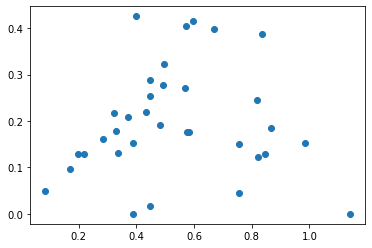

In [71]:
import matplotlib.pyplot as plt

plt.scatter(np.array(output[:,0]).ravel(), np.array(output[:,1]).ravel())

# Part II